# Проект по предсказанию стоимости жилья

### Подгрузим нужные библиотеки  и пропишем функции

#### Библиотеки для работы с данными

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
from IPython.core.display import display, HTML

display(HTML("<style>div.output_scroll { height: 40em; }</style>"))
now = datetime.datetime.now()
%matplotlib inline

#### Библиотеки sklearn

In [2]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score as acc_sc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import  GradientBoostingRegressor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN


In [3]:
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 12})  # размер шрифта на графиках

#### Пропишем пути к файлам и загрузим данные

In [4]:
DATA_PATH_TRAIN = 'train.csv'
DATA_TEST_PATH = 'test.csv'
DATA_PREPARED_PATH = '/data_prepared/'
SCALE_PATH = './scale/'
MODEL_PATH = './models/'

In [5]:
df_train = pd.read_csv('train.csv', sep = ',')
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

#### Пропишем функция для уменьшения памяти и для оценки результатов

In [6]:
#Функция для переработки памяти
def memmory_reduce(df_input):
    df = df_input
    mem_before = df.memory_usage().sum()/1024**2
    print(f'Mem. before reduce: {mem_before}')
    for  i in df.columns:
        i_type = df[i].dtype
        if str(i_type)[:3] == 'int':
            i_min = df[i].min()
            i_max = df[i].max()
            if i_max < np.iinfo(np.int8).max:
                df[i] = df[i].astype(np.int8)
            elif i_max > np.iinfo(np.int16).min and i_max < np.iinfo(np.int16).max:
                df[i] = df[i].astype(np.int16)
            elif i_max > np.iinfo(np.int32).min and i_max < np.iinfo(np.int32).max:
                df[i] = df[i].astype(np.int32)
            elif i_max > np.iinfo(np.int64).min and i_max < np.iinfo(np.int64).max:
                df[i] = df[i].astype(np.int32) 
        elif str(i_type)[:5] == 'float':
            if i_max < np.finfo(np.float32).max:
                df[i] = df[i].astype(np.float32)
            else:
                df[i] = df[i].astype(np.float64)
    mem_after = df.memory_usage().sum()/1024**2
    print(f'Mem. after reduce: {mem_after}')
    return df
#df_train = memmory_reduce(df_train)

Функция для вычисления и отображения ошибок и фукнция для построения результатов на предсказанных данных и на 

In [7]:
#Функция для вычисления и отображения ошибок
def predict_error(y_pred, y_true, metric = 'r2'):
    if metric == 'r2':
        print(f'Ошибка R2: {r2(y_true, y_pred)}')
    elif metric == 'mse':
        print(f'Ошибка MSE: {mse(y_true, y_pred)}')
    elif metric == 'acc_sc':
        print(f'Ошибка Acc_sc: {acc_sc(y_true, y_pred)}')
        
#фукнция для построения графиков на тренировочном и тестовом объеме данных       
def pred_test_plot(y_pred_tr, y_true_tr, y_pred_tst, y_true_tst):
    plt.figure(figsize= (20,10))
    
    plt.subplot(121)
    plt.scatter(y_pred_tr, y_true_tr)
    plt.xlabel('Pred. values')
    plt.ylabel('True values')
    plt.title('Train')
    
    plt.subplot(122)
    plt.scatter(y_pred_tst, y_true_tst)
    plt.xlabel('Pred. values')
    plt.ylabel('True values')
    plt.title('Test')
    
    plt.show()
    

def pred_test_plot(y_pred_tr, y_true_tr, y_pred_tst, y_true_tst):
    plt.figure(figsize= (20,10))
    
    plt.subplot(121)
    plt.scatter(y_pred_tr, y_true_tr)
    plt.xlabel('Pred. values')
    plt.ylabel('True values')
    plt.title('Train')
    
    plt.subplot(122)
    plt.scatter(y_pred_tst, y_true_tst)
    plt.xlabel('Pred. values')
    plt.ylabel('True values')
    plt.title('Test')
    
    plt.show()


### EDA

**Целевая переменная**

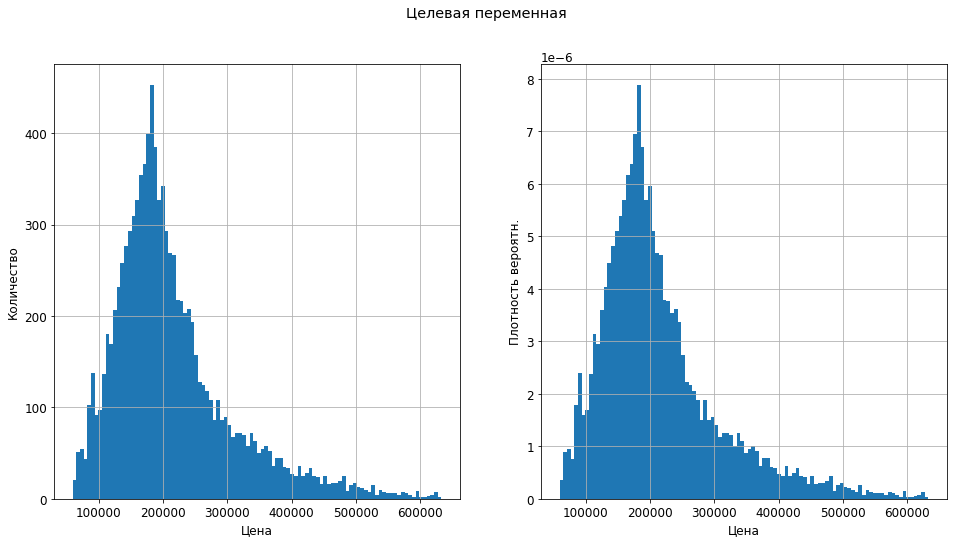

In [8]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
df_train['Price'].hist(bins=100)
plt.ylabel('Количество')
plt.xlabel('Цена')

plt.subplot(122)
df_train['Price'].hist(bins=100, density = True)
plt.ylabel('Плотность вероятн.')
plt.xlabel('Цена')


plt.suptitle('Целевая переменная')
plt.show()

Целевая переменная распредлена достаточно неплохо, не видно явных выбросов, поэтому ее трогать не будем.

**Количественные переменные**

In [9]:
df_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


**Категориальные переменные**

DistrictId - так же категориальная переменная, переведем её в строку

Рассмотрим все категориальные переменные

In [10]:
df_train.DistrictId = df_train.DistrictId.astype('str')
df_train.select_dtypes(include='object').columns.tolist()

['DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [11]:
df_train.DistrictId.value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
207      1
196      1
199      1
209      1
205      1
Name: DistrictId, Length: 205, dtype: int64

In [12]:
df_train.Ecology_2.value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [13]:
df_train.Ecology_3.value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [14]:
df_train.Shops_2.value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

### Обработка данных

#### Обработка выбросов

***Rooms***`

In [15]:
df_train.Rooms.value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

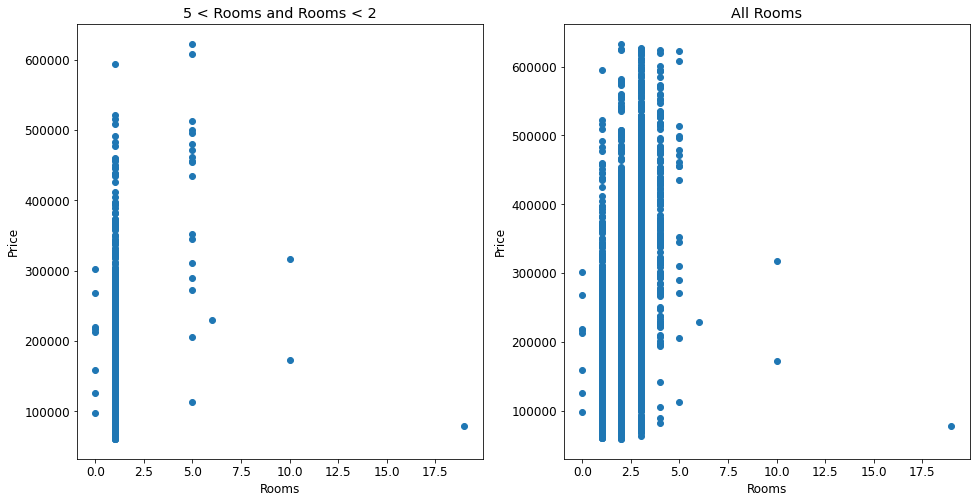

In [16]:
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.scatter(df_train.Rooms[(df_train.Rooms > 4) | (df_train.Rooms < 2)],df_train.Price[(df_train.Rooms > 4) | (df_train.Rooms < 2)])
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('5 < Rooms and Rooms < 2')

plt.subplot(122)
plt.scatter(df_train.Rooms,df_train.Price)
plt.xlabel('Rooms')
plt.ylabel('Price')
plt.title('All Rooms')

plt.show()

есть выбросы больше 5 и меньше 1. Больше 10 - делится на два сегмента, те, что слишком большие, такие как 19 - это явная ошибка, и те что меньше 10. Из графика количства комнат/ цена, можно сделать вывод, что от 6 до 7 комнат(такие квартиры могут попадаться) можно заменить на 5. Для выбросов меньше 1 - заменим всё на 1

In [17]:
df_train['Rooms_outlier'] = 0
med_Rooms = df_train['Rooms'].median()
df_train.loc[(df_train['Rooms'] < 1) | (df_train['Rooms'] > 5), 'Rooms_outlier'] = 1
df_train.loc[(df_train['Rooms'] > 5) & (df_train['Rooms'] < 8), 'Rooms'] = 5
df_train.loc[(df_train['Rooms'] > 8), 'Rooms'] = med_Rooms
df_train.loc[(df_train['Rooms'] < 1), 'Rooms'] = 1
df_train.Rooms.value_counts()

2.0    3883
1.0    3713
3.0    2235
4.0     150
5.0      19
Name: Rooms, dtype: int64

***Square***

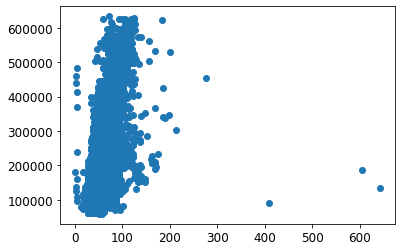

In [18]:
plt.scatter(df_train.Square, df_train.Price)

In [19]:
df_train.Square.quantile(0.995) , df_train.Square.quantile(0.005)

(132.82090134811978, 27.24540933053085)

Переда подсчетом выбросов посчитаем параметры для дальнейшего подсчета LifeSquare и подсчета KitchenSquare

In [20]:
#Расчет параметров для заполнений пустых значений LifeSquare
lst_med = []
lst_ind = []
Square_Life_med = (df_train.Square - df_train.LifeSquare).median()
for i in df_train.Rooms.unique():
    lst_ind.append(i)
    lst_med.append(df_train[df_train.Rooms == i].LifeSquare.median())
Life_Square_med = pd.Series(data = lst_med, index = lst_ind)
Life_Square_med

3.0    46.960480
1.0    21.663951
2.0    32.552744
4.0    64.946548
5.0    79.795451
dtype: float64

Логично предположить, что при большей плозади - цена будет больше, однако, при очень больших площадях, есть данные с маленькой ценой. Очевидно, что это выбросы. Данные больше персентиля 0,995 будем заменять на медианное значение.
Так же меньше персентиля 0.005 будем обрезать персентилем 0.005

In [21]:
df_train['Square_outlier'] = 0
med_Square = df_train['Square'].median()
Square_min = df_train.Square.quantile(0.005)
Square_max = df_train.Square.quantile(0.995)
df_train.loc[(df_train['Square'] < Square_min) | (df_train['Square'] > Square_max ), 'Square_outlier'] = 1
df_train.loc[(df_train['Square'] > Square_max) , 'Square'] = med_Rooms
df_train.loc[(df_train['Square'] < Square_min) , 'Square'] = Square_min
df_train.Square.describe()

count    10000.000000
mean        55.589276
std         17.750257
min         27.245409
25%         41.639670
50%         52.235120
75%         65.687443
max        132.820646
Name: Square, dtype: float64

***KitchenSquare***

In [22]:
df_train['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
43.0         2
112.0        2
41.0         2
32.0         2
58.0         2
25.0         2
37.0         2
30.0         2
51.0         2
40.0         1
96.0         1
48.0         1
72.0         1
73.0         1
2014.0       1
66.0         1
36.0         1
78.0         1
54.0         1
29.0         1
31.0         1
35.0         1
62.0         1
39.0         1
1970.0       1
60.0         1
75.0         1
26.0         1
21.0         1
84.0         1
63.0         1
123.0        1
53.0         1
42.0         1
23.0         1
27.0         1
Name: KitchenSquare, dtype: int64

Видно, что есть кухни, где площадь <= 2, это видимо студии. Больше всего данных = 1.
Не будем избавляться от этого класса данных, а, наоборот, все данные = 2 и 0, приравняем к 1.
При этом данные больше персентиля 0.99 приравняем к персентилю 0.99.

In [23]:
df_train['KitchenSquare_outlier'] = 0
KitchenSquare_max = df_train.KitchenSquare.quantile(0.99)
df_train.loc[(df_train.KitchenSquare > df_train.KitchenSquare.quantile(0.99)) | (df_train.KitchenSquare <= 2), \
            'KitchenSquare_outlier'] = 1
df_train.loc[(df_train.KitchenSquare > KitchenSquare_max), 'KitchenSquare'] = KitchenSquare_max
df_train.loc[(df_train.KitchenSquare <= 2), 'KitchenSquare'] = 1

***LifeSquare***

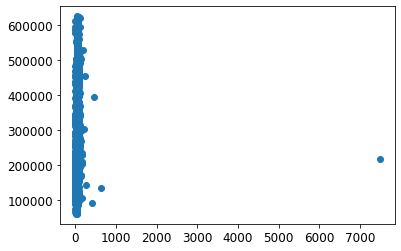

In [24]:
plt.scatter(df_train.LifeSquare, df_train.Price)

plt.show()

Cделаем дополнительную колонку LifeSquаre2, для двух вариантов работы с выбросами и заполнения пропусков. В первом случае мы будем менять выбросы и заполнять пропуски разницой Square и медианным значением разницы Square - LifeSqure, посчитанным ранее, во втором средним значеним LifeSquare, относительно количества комнат. 

In [25]:
df_train['LifeSquare_outlier'] = 0
df_train['LifeSquare2'] = df_train['LifeSquare']
df_train.loc[(df_train.LifeSquare > df_train.LifeSquare.quantile(0.995)) | (df_train.LifeSquare < df_train.LifeSquare.quantile(0.005)), 'LifeSquare_outlier'] = 1
df_train.LifeSquare[df_train.LifeSquare_outlier == 1] = df_train.Square[df_train.LifeSquare_outlier == 1] - Square_Life_med
for i in Life_Square_med.index:
    df_train.LifeSquare2[(df_train.LifeSquare_outlier == 1) & (df_train.Rooms == i)] = Life_Square_med[i]

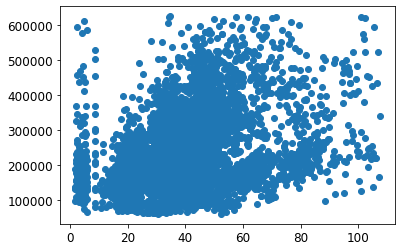

In [26]:
plt.scatter(df_train.LifeSquare, df_train.Price)

plt.show()

***Floor, HouseFloor***

In [27]:
df_train.Floor.sort_values(ascending = False)

4987    42
7599    37
2383    33
7984    32
1360    32
        ..
3195     1
7845     1
9392     1
9869     1
4982     1
Name: Floor, Length: 10000, dtype: int64

In [28]:
df_train.HouseFloor.sort_values(ascending = False)

1678    117.0
4657     99.0
746      99.0
4987     48.0
5031     48.0
        ...  
6860      0.0
6870      0.0
5104      0.0
1928      0.0
2768      0.0
Name: HouseFloor, Length: 10000, dtype: float64

In [29]:
df_train.HouseFloor[(df_train.HouseFloor < 1)].value_counts()

0.0    269
Name: HouseFloor, dtype: int64

In [30]:
df_train.loc[((df_train.HouseFloor < 1) & (df_train.Floor != 0))]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,LifeSquare2
24,4717,27,1.0,44.203947,NaN,1.0,2,0.0,1977,0.072158,...,NaN,0,0,A,135466.559958,0,0,1,0,NaN
152,12947,53,2.0,56.023342,NaN,1.0,14,0.0,1977,0.049637,...,229.0,1,3,B,247074.564832,0,0,1,0,NaN
159,13146,74,1.0,46.449711,NaN,1.0,6,0.0,1977,0.075779,...,NaN,0,2,B,168705.450148,0,0,1,0,NaN
186,12174,62,1.0,44.954880,NaN,1.0,8,0.0,1977,0.072158,...,NaN,0,0,A,133773.301722,0,0,1,0,NaN
229,15661,45,3.0,81.094922,NaN,1.0,15,0.0,1977,0.195781,...,NaN,3,2,B,442472.456032,0,0,1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9889,629,27,1.0,42.936724,NaN,1.0,2,0.0,1977,0.011654,...,NaN,0,0,B,129674.841139,0,0,1,0,NaN
9931,15686,1,1.0,47.402412,NaN,1.0,14,0.0,1977,0.007122,...,NaN,0,1,B,174740.301224,0,0,1,0,NaN
9940,4711,6,1.0,41.224118,NaN,1.0,8,0.0,1977,0.243205,...,540.0,0,0,B,125612.639104,0,0,1,0,NaN
9950,5383,48,3.0,98.994909,NaN,1.0,3,0.0,1977,0.041125,...,NaN,1,10,B,418817.004446,0,0,1,0,NaN


замети, что Floor вроде заполнен корректными данными. HouseFloor заполнен не совсем верно. Много данных, где HouseFloor < 1,
при этом Floor во всех этих данных != 0. Заполним нули в HouseFloor и элементы, где HouseFloor < Floor значением Floor.  

In [31]:
df_train.loc[(df_train.HouseFloor < 1) | (df_train.HouseFloor < df_train.Floor), 'HouseFloor'] = df_train.Floor
df_train.HouseFloor[(df_train.HouseFloor < 1) | (df_train.HouseFloor < df_train.Floor)].value_counts()

Series([], Name: HouseFloor, dtype: int64)

Так же заметим, что есть данные с очень большими этажами. Ограничим их значеним 48, которое кажется верным.

In [32]:
df_train.HouseFloor[df_train.HouseFloor > 48] = 48

***HouseYear***

In [33]:
df_train.HouseYear.value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1947           1
1916           1
1910           1
1928           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

Есть значения, которые явно явно заполнены неверно. Заменим их текущим годом

In [34]:
df_train.HouseYear[df_train.HouseYear > 2020] = now.year

#### Обработка пропусков

In [35]:
df_train.isna().sum()

Id                          0
DistrictId                  0
Rooms                       0
Square                      0
LifeSquare               2113
KitchenSquare               0
Floor                       0
HouseFloor                  0
HouseYear                   0
Ecology_1                   0
Ecology_2                   0
Ecology_3                   0
Social_1                    0
Social_2                    0
Social_3                    0
Healthcare_1             4798
Helthcare_2                 0
Shops_1                     0
Shops_2                     0
Price                       0
Rooms_outlier               0
Square_outlier              0
KitchenSquare_outlier       0
LifeSquare_outlier          0
LifeSquare2              2113
dtype: int64

***LifeSquare***

Заполним пропуски в вух вариантах,  как описано выше

In [36]:
df_train['LifeSquare_NA'] = 0
df_train.loc[df_train.LifeSquare.isna(), 'LifeSquare_NA'] = 1
df_train.LifeSquare[df_train.LifeSquare_NA == 1] = df_train.Square[df_train.LifeSquare_NA == 1] - Square_Life_med
for i in Life_Square_med.index:
    df_train.LifeSquare2[(df_train.LifeSquare_NA == 1) & (df_train.Rooms == i)] = Life_Square_med[i]

***HealthCare_1***

В данной фиче почти половина данных - пустая. Хочется ее удалить, но попробуем заполнить её и потом на обучении будем смотреть на её влияние. Построим зависимость среднего от района и второго показателя здоровья 

In [37]:
df_train.pivot_table(values = 'Healthcare_1', index = 'DistrictId', columns = 'Helthcare_2', aggfunc = 'median')

Helthcare_2,0,1,2,3,4,5,6
DistrictId,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,2857.0,645.0
1,NaN,200.0,NaN,240.0,NaN,NaN,NaN
100,NaN,NaN,770.0,NaN,NaN,NaN,NaN
101,NaN,NaN,1015.0,1548.0,NaN,NaN,NaN
102,NaN,NaN,NaN,705.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
93,NaN,NaN,30.0,NaN,NaN,NaN,NaN
95,4129.0,1786.0,NaN,2300.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,1575.0,NaN


Здесь слишком много пустых значений, попробуем сгруппировать данные по категориальным данным экологии и второй фиче здоровья, так как скорее всего здоровье как то связано с экологией

In [38]:
Grouped_to_HC1 = df_train.groupby(['Helthcare_2', 'Ecology_2', 'Ecology_3'],\
                                  as_index = False).agg({'Healthcare_1':'median'}).rename(columns = {'Healthcare_1': 'HC1_med'})
Grouped_to_HC1

,Helthcare_2,Ecology_2,Ecology_3,HC1_med
0,0,A,B,370.0
1,0,B,B,540.0
2,1,B,A,1130.0
3,1,B,B,320.0
4,2,B,A,325.0
5,2,B,B,750.0
6,3,A,B,1548.0
7,3,B,A,4508.0
8,3,B,B,1046.0
9,4,B,A,830.0


Этими данными уже можно заполнить пустые значения

In [39]:
df_train['Healthcare1_NA'] = 0
df_train.loc[df_train.Healthcare_1.isnull(), 'Healthcare1_NA'] = 1

In [40]:
#создадим таблицу с заполнеными данными по Healthcare_1 и Id
df_for_Healthcare = df_train[['Id','Helthcare_2', 'Ecology_2', 'Ecology_3']]
df_for_Healthcare = df_for_Healthcare.merge(Grouped_to_HC1, on=['Helthcare_2', 'Ecology_2', 'Ecology_3'], how='left')
df_for_Healthcare

,Id,Helthcare_2,Ecology_2,Ecology_3,HC1_med
0,11809,0,B,B,540.0
1,3013,1,B,B,320.0
2,8215,3,B,B,1046.0
3,2352,0,B,B,540.0
4,13866,0,B,B,540.0
...,...,...,...,...,...
9995,1260,1,B,B,320.0
9996,16265,0,B,B,540.0
9997,2795,1,B,B,320.0
9998,14561,3,B,B,1046.0


In [41]:
df_train = df_train.merge(df_for_Healthcare[['Id', 'HC1_med']], on = ['Id'], how = 'left')

In [42]:
df_train.loc[(df_train['Healthcare1_NA'] == 1), 'Healthcare_1'] = df_train.HC1_med[df_train['Healthcare1_NA'] == 1]

In [43]:
df_train.isnull().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1             0
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
Square_outlier           0
KitchenSquare_outlier    0
LifeSquare_outlier       0
LifeSquare2              0
LifeSquare_NA            0
Healthcare1_NA           0
HC1_med                  0
dtype: int64

In [76]:
class DataPreprocessing:
    def __init__(self):
        self.medians = None
        self.med_Rooms = None
        self.med_Square = None
        self.Square_min = None
        self.Square_max = None
        self.Square_Life_med = None
        self.Life_Square_med = None
        self.KitchenSquare_max = None
        self.Grouped_to_HC1 = None
        self.LifeSquare_max = None
        self.LifeSquare_min = None
        
        
    def fit(self, X):
        self.medians = X.median()
        self.med_Rooms = X.Rooms.median()
        self.med_Square = X['Square'].median()
        self.Square_min = X['Square'].quantile(0.005)
        self.Square_max = X['Square'].quantile(0.995)
        self.LifeSquare_max = X.LifeSquare.quantile(0.995)
        self.LifeSquare_min = X.LifeSquare.quantile(0.005)
        #Расчет параметров для заполнений пустых значений LifeSquare
        lst_med = []
        lst_ind = []
        self.Square_Life_med = (X['Square'] - X['LifeSquare']).median()
        for i in X['Rooms'].unique():
            lst_ind.append(i)
            lst_med.append(X[X['Rooms'] == i].LifeSquare.median())
        self.Life_Square_med = pd.Series(data = lst_med, index = lst_ind)
        self.KitchenSquare_max = X.KitchenSquare.quantile(0.99)
        self.Grouped_to_HC1 = X.groupby(['Helthcare_2', 'Ecology_2', 'Ecology_3'],\
                                  as_index = False).agg({'Healthcare_1':'median'}).rename(columns = {'Healthcare_1': 'HC1_med'})

    
        
    def transform(self, X):
        #Обработка пропусков
        #Rooms
        X['DistrictId'] = X['DistrictId'].astype(str)
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] < 1) | (X['Rooms'] > 5), 'Rooms_outlier'] = 1
        X.loc[(X['Rooms'] > 5) & (X['Rooms'] < 8), 'Rooms'] = 5
        X.loc[(X['Rooms'] > 8), 'Rooms'] = self.med_Rooms
        X.loc[(X['Rooms'] < 1), 'Rooms'] = 1
        X.Rooms.value_counts()
        
        #Square
        X['Square_outlier'] = 0
        X.loc[(X['Square'] < self.Square_min) | (X['Square'] > self.Square_max ), 'Square_outlier'] = 1
        X.loc[(X['Square'] > self.Square_max) , 'Square'] = self.med_Square
        X.loc[(X['Square'] < self.Square_min) , 'Square'] = self.Square_min
        
        
        #KitchenSquare
        X['KitchenSquare_outlier'] = 0
        X.loc[(X.KitchenSquare > self.KitchenSquare_max) | (X.KitchenSquare <= 2), \
            'KitchenSquare_outlier'] = 1
        X.loc[(X.KitchenSquare > self.KitchenSquare_max), 'KitchenSquare'] = self.KitchenSquare_max
        X.loc[(X.KitchenSquare <= 2), 'KitchenSquare'] = 1
        
        #LifeSquare
        X['LifeSquare_outlier'] = 0
        X['LifeSquare2'] = X['LifeSquare']
        X.loc[(X.LifeSquare > self.LifeSquare_max) | (X.LifeSquare < self.LifeSquare_min), 'LifeSquare_outlier'] = 1
        X.LifeSquare[X.LifeSquare_outlier == 1] = X.Square[X.LifeSquare_outlier == 1] - self.Square_Life_med
        for i in self.Life_Square_med.index:
            X.LifeSquare2[(X.LifeSquare_outlier == 1) & (X.Rooms == i)] = self.Life_Square_med[i]
            
        #HouseFloor
        X.loc[(X.HouseFloor < 1) | (X.HouseFloor < X.Floor), 'HouseFloor'] = X.Floor
        X.HouseFloor[X.HouseFloor > 48] = 48
        
        #HouseYear
        X.HouseYear[X.HouseYear > 2020] = now.year
        
        
        #Обработка выбросов
        #LifeSquare
        X['LifeSquare_NA'] = 0
        X.loc[X.LifeSquare.isna(), 'LifeSquare_NA'] = 1
        X.LifeSquare[X.LifeSquare_NA == 1] = X.Square[X.LifeSquare_NA == 1] - self.Square_Life_med
        for i in self.Life_Square_med.index:
            X.LifeSquare2[(X.LifeSquare_NA == 1) & (X.Rooms == i)] = self.Life_Square_med[i]
        #Healthcare_1 
        X['Healthcare1_NA'] = 0
        X.loc[X.Healthcare_1.isnull(), 'Healthcare1_NA'] = 1
        df_for_Healthcare = X[['Id','Helthcare_2', 'Ecology_2', 'Ecology_3']]
        df_for_Healthcare = df_for_Healthcare.merge(self.Grouped_to_HC1,\
                                                    on=['Helthcare_2', 'Ecology_2', 'Ecology_3'], how='left')
        X = X.merge(df_for_Healthcare[['Id', 'HC1_med']], on = ['Id'], how = 'left')
        X.loc[(X['Healthcare1_NA'] == 1), 'Healthcare_1'] = X.HC1_med[X['Healthcare1_NA'] == 1]
        
        X.fillna(self.medians, inplace=True)
        
        return X

df_train = pd.read_csv('train.csv', sep = ',')
procc = DataPreprocessing()
procc.fit(df_train)
df_train = procc.transform(df_train)

#### Создание новых фич

***Dummy***

In [45]:
change_dict = {'A' : 0, 'B' : 1}
df_train[['Shops_2','Ecology_2', 'Ecology_3']] = df_train[['Shops_2','Ecology_2', 'Ecology_3']].replace(change_dict)

***Cluster***

Попробуем выполнить понижение размерности

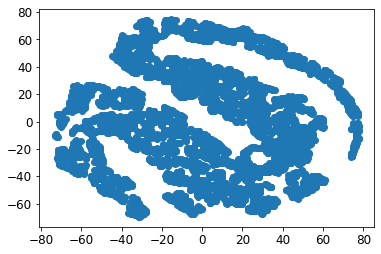

In [46]:
tsne = TSNE(n_components=2, learning_rate=100, random_state=100)

df_train_tsne = tsne.fit_transform(df_train)
plt.scatter(df_train_tsne[:, 0], df_train_tsne[:, 1])

plt.show()

Видно, что данные представлены хорошо и можно попробовать сделать кластеризацию. Было выялвено, что KMeans с делением на 5ть кластеров справляется наилучшим образом с данной задачей

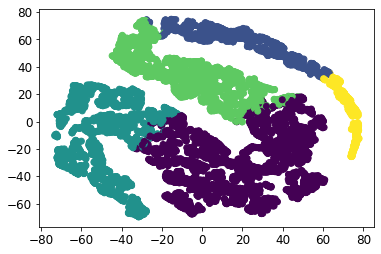

In [47]:
KM_mdl = KMeans(n_clusters=5, random_state=42, max_iter = 100)
train_labels = KM_mdl.fit_predict(df_train)
plt.scatter(df_train_tsne[:, 0], df_train_tsne[:, 1],  c = train_labels)

plt.show()

In [48]:
df_train['Cluster'] = train_labels
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,Square_outlier,KitchenSquare_outlier,LifeSquare_outlier,LifeSquare2,LifeSquare_NA,Healthcare1_NA,HC1_med,Cluster
0,11809,27,3.0,115.027311,96.563211,10.0,4,10.0,2014,0.075424,...,305018.871089,0,0,0,0,46.960480,1,1,540.0,1
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,0,23.169223,0,0,320.0,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,0,47.671972,0,0,1046.0,3
3,2352,1,1.0,40.409907,21.945807,1.0,10,22.0,1977,0.007122,...,168106.007630,0,0,1,0,21.663951,1,1,540.0,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,0,38.562517,0,1,540.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,119367.455796,0,0,0,0,33.272626,0,1,320.0,2
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,...,199715.148807,0,0,0,0,37.038420,0,1,540.0,0
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,...,165953.912580,0,0,0,0,16.555363,0,1,320.0,0
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,171842.411855,0,0,0,0,22.326870,0,0,1046.0,0


***DistricPopularity, DistrictWeight***

Введем два новых признака DistrictPopularity - количество каждого района и DisrtictWeight - процент района от общего числа переменных(вес района) 

In [49]:
popular = df_train.groupby('DistrictId').agg({'DistrictId': 'count'}).rename(columns = {'DistrictId': 'DistrictPopularity'})
popular = popular.sort_values(by = 'DistrictPopularity', ascending = False).reset_index()
District_part = pd.DataFrame({'DistrictPopularity' : popular.DistrictPopularity.sort_values().unique(),\
                              'DistrictWeight' :  popular.DistrictPopularity.sort_values().unique() / 10000})
popular = popular.merge(District_part, on = 'DistrictPopularity', how = 'left')
df_train = df_train.merge(popular, on = 'DistrictId')

***SquareVeracity***

In [50]:
(df_train['Square'] < df_train['LifeSquare'] + df_train['KitchenSquare']).sum()

842

Введем переменную, которая будет показывать, когда площадь меньше суммы площадей жилой площади и кухни(достоверность площади)

In [51]:
df_train['SquareVeracity'] = 1
df_train.loc[(df_train['Square'] < df_train['LifeSquare'] + df_train['KitchenSquare']), 'SquareVeracity'] = 0

***medPrDistrYear***

Посмотрим зависимость цены от года, видны большие кластеры

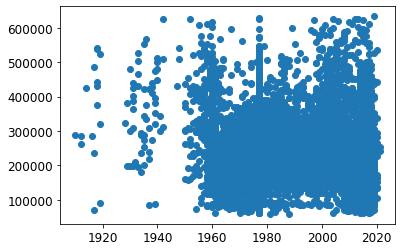

In [52]:
plt.scatter(df_train.HouseYear, df_train.Price)

In [53]:
def feature_cat(X, column, bins):
    new_column = column + '_devide'
    X[column + '_devide'] = pd.cut(X[column], bins=bins, labels=False)
    
    X[column + '_devide'].fillna(-1, inplace=True)
    return X


In [54]:
bins_year = [0, 1930, 1950, 1970, 1990,2000, 2021]
df_train = feature_cat(df_train, 'HouseYear', bins_year)

Посмотрим на заисимость года от квартала, здесь тоже просмотривается некоторая закономерность

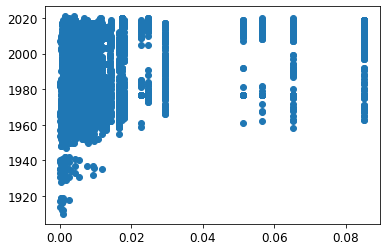

In [55]:
plt.scatter(df_train.DistrictWeight, df_train.HouseYear)

Предположим, что цена зависит от веса района и от года постройки дома. Вес района при этом мы разаобьем на три группы

In [56]:
bins = [0, 0.02, 0.07, 1]
df_train = feature_cat(df_train, 'DistrictWeight', bins)

In [57]:
med_price_by_distr_year = df_train.groupby(['DistrictWeight_devide', 'HouseYear_devide'], \
                     as_index = False ).agg({'Price' : 'median'}).rename(columns = {'Price' : 'medPrDistrYear' } )
med_price_by_distr_year

,DistrictWeight_devide,HouseYear_devide,medPrDistrYear
0,0,0,322905.044793
1,0,1,366653.849466
2,0,2,193353.221289
3,0,3,207909.098352
4,0,4,244351.989279
5,0,5,256252.283371
6,1,2,152757.840502
7,1,3,165602.528456
8,1,4,195274.434071
9,1,5,152464.848743


Здесь видна некая закономерность, значит добавим такую переменную в наш датасет

In [58]:
df_train = df_train.merge(med_price_by_distr_year, on = ['DistrictWeight_devide', 'HouseYear_devide'], how = 'left' )

***medPrFloorRooms***

Разделим все этажи на 3и категории и посмотрим зависимость цены от категории этажа и колчиества комнат

In [59]:
bins_Floor = [0, df_train['Floor'].quantile(0.33), df_train['Floor'].quantile(0.66), df_train['Floor'].max()]

df_train = feature_cat(df_train, 'Floor', bins_Floor)

In [60]:
med_price_by_floor_rooms = df_train.groupby(['Floor_devide', 'Rooms'], \
                     as_index = False ).agg({'Price' : 'median'}).rename(columns = {'Price' : 'medPrFloorRooms' } )
med_price_by_floor_rooms

,Floor_devide,Rooms,medPrFloorRooms
0,0,1.0,151335.688391
1,0,2.0,191009.072406
2,0,3.0,251055.690010
3,0,4.0,351738.389958
4,0,5.0,310305.074733
5,1,1.0,157499.188345
6,1,2.0,204421.539120
7,1,3.0,272178.749159
8,1,4.0,373510.057128
9,1,5.0,479525.147323


Есть некоторые отличия в категориях, поэтому данную переменную тоже будем использовать в нашем датасете

In [61]:
df_train = df_train.merge(med_price_by_floor_rooms, on = ['Floor_devide', 'Rooms'], how = 'left' )

***medPrSqRooms***

Логично предположить, что цена будет зависить от площади и количества комнат. Разделим площадь на три категории и сгруппируем данные. После этого добавим в датасет

In [62]:
bins_Square = [0, df_train['Square'].quantile(0.33), df_train['Square'].quantile(0.66), df_train['Square'].max()]

df_train = feature_cat(df_train, 'Square', bins_Square)

med_price_by_Rooms_square= df_train.groupby(['Square_devide', 'Rooms'], \
                     as_index = False ).agg({'Price' : 'median'}).rename(columns = {'Price' : 'medPrSqRooms' } )
med_price_by_Rooms_square

,Square_devide,Rooms,medPrSqRooms
0,0,1.0,155487.356111
1,0,2.0,190132.996752
2,0,3.0,195831.983247
3,0,4.0,414427.775300
4,0,5.0,348917.082537
5,1,1.0,148890.900714
6,1,2.0,207218.127195
7,1,3.0,228590.539282
8,1,4.0,201374.604049
9,1,5.0,229661.964416


In [64]:
df_train = df_train.merge(med_price_by_Rooms_square, on = ['Square_devide', 'Rooms'], how = 'left' )

***medPrSqFloor***

Рассмотрим зависимость цены от площади и этажа

In [65]:

med_price_by_floor_square= df_train.groupby(['Square_devide', 'Floor_devide'], \
                        as_index = False ).agg({'Price' : 'median'}).rename(columns = {'Price' : 'medPrSqFloor' } )

med_price_by_floor_square

,Square_devide,Floor_devide,medPrSqFloor
0,0,0,159156.866791
1,0,1,162666.874982
2,0,2,158294.793125
3,1,0,193241.905192
4,1,1,200573.760515
5,1,2,204373.133307
6,2,0,241697.820327
7,2,1,256363.236588
8,2,2,250122.101897


In [66]:
df_train = df_train.merge(med_price_by_floor_square, on = ['Square_devide', 'Floor_devide'], how = 'left' )

In [134]:
class FeatureCreation:
    def __init__(self):
        self.change_dict = None
        self.KM_mdl = None
        self.popular = None
        self.District_part = None
        self.med_price_by_distr_year = None
        self.med_price_by_distr_year_med = None
        self.bins_year = None
        self.med_price_by_floor_rooms = None
        self.med_price_by_floor_rooms_med = None
        self.bins_Square = None
        self.med_price_by_Rooms_square= None
        self.med_price_by_Rooms_square_med =  None
        self.med_price_by_floor_square= None
        self.med_price_by_floor_square_med =None
        self.bins = None
        
    def feature_cat(X, column, bins):
        new_column = column + '_devide'
        X[column + '_devide'] = pd.cut(X[column], bins=bins, labels=False)
    
        X[column + '_devide'].fillna(-1, inplace=True)
        return X
    
    
    def fit(self, X, y = None):
        X = X.copy()
        
        #dummy
        self.change_dict = {'A' : 0, 'B' : 1}
        X[['Shops_2','Ecology_2', 'Ecology_3']] = X[['Shops_2','Ecology_2', 'Ecology_3']].replace(self.change_dict)
        #cluster
        self.KM_mdl = KMeans(n_clusters=5, random_state=42, max_iter = 100).fit(X)
        #DistrictWeight, DistrictPop
        self.popular = X.groupby('DistrictId').agg({'DistrictId': 'count'}).rename(columns = {'DistrictId': 'DistrictPopularity'})
        self.popular = popular.sort_values(by = 'DistrictPopularity', ascending = False).reset_index()
        self.District_part = pd.DataFrame({'DistrictPopularity' : self.popular.DistrictPopularity.sort_values().unique(),\
                              'DistrictWeight' :  self.popular.DistrictPopularity.sort_values().unique() / len(X)})
        self.popular = popular.merge(self.District_part, on = 'DistrictPopularity', how = 'left')
        
        
        #TargetEncoding
        #District, Year
        df = X.copy()
        if y is not None:
            df['Price'] = y
            self.bins_Floor = [0, df['Floor'].quantile(0.33), df['Floor'].quantile(0.66), df['Floor'].max()]
            df = feature_cat(df, 'Floor', self.bins_Floor)
            self.med_price_by_floor_rooms = df.groupby(['Floor_devide', 'Rooms'], \
                    as_index = False ).agg({'Price' : 'median'}).rename(columns = {'Price' : 'medPrFloorRooms' } )
            self.med_price_by_floor_rooms_med =   self.med_price_by_floor_rooms['medPrFloorRooms']
        #Square, Rooms
        if y is not None: 
            self.bins_Square = [0, df['Square'].quantile(0.33), df['Square'].quantile(0.66), df['Square'].max()]

            self.df_train = feature_cat(df, 'Square', self.bins_Square)

            self.med_price_by_Rooms_square= df.groupby(['Square_devide', 'Rooms'], \
                     as_index = False ).agg({'Price' : 'median'}).rename(columns = {'Price' : 'medPrSqRooms' } )
            self.med_price_by_Rooms_square_med =  self.med_price_by_Rooms_square['medPrSqRooms'].median()
        #Square, Floor
        if y is not None: 
            self.med_price_by_floor_square= df.groupby(['Square_devide', 'Floor_devide'], \
                        as_index = False ).agg({'Price' : 'median'}).rename(columns = {'Price' : 'medPrSqFloor' } )
            self.med_price_by_floor_square_med = self.med_price_by_floor_square['medPrSqFloor'].median()
        return X
        
    def transform(self,X):
        #dummy
        X[['Shops_2','Ecology_2', 'Ecology_3']] = X[['Shops_2','Ecology_2', 'Ecology_3']].replace(self.change_dict)
        #cluster
        labels = self.KM_mdl.predict(X)
        X['Cluster'] = labels
        #District
        X = X.merge(self.popular, on = 'DistrictId')
        X['new_district'] = 0
        X.loc[X['DistrictPopularity'].isna(), 'new_district'] = 1
        X['DistrictPopularity'].fillna(5, inplace=True)
        #SquareVeracity
 #       X['SquareVeracity'] = 1
#        X.loc[(df_train['Square'] < X['LifeSquare'] + X['KitchenSquare']), 'SquareVeracity'] = 0
        #TargetEncoding
        if self.med_price_by_floor_rooms is not None:
            X = feature_cat(X, 'Floor', self.bins_Floor)
            X = X.merge(self.med_price_by_floor_rooms, on = ['Floor_devide', 'Rooms'], how = 'left' )
            X.fillna(self.med_price_by_floor_rooms_med, inplace=True)
        if self.med_price_by_Rooms_square is not None:
            X = feature_cat(X, 'Square', self.bins_Floor)
            X = X.merge(self.med_price_by_Rooms_square, on = ['Square_devide', 'Rooms'], how = 'left' )
            X.fillna(self.med_price_by_Rooms_square_med, inplace=True)
        if self.med_price_by_floor_square is not None:
            X = X.merge(self.med_price_by_floor_square, on = ['Square_devide', 'Floor_devide'], how = 'left' )
            X.fillna(self.med_price_by_floor_square_med, inplace=True)
        
        
        
        
        return X

In [118]:
df_train = pd.read_csv('train.csv', sep = ',')
proc = DataPreprocessing()
y = df_train['Price']
proc.fit(df_train)
df_train = proc.transform(df_train)
feats = FeatureCreation()
feats.fit(df_train.drop('Price', axis = 1), y = y)
df_train = feats.transform(df_train.drop('Price', axis = 1))
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,DistrictPopularity,DistrictWeight_x,DistrictWeight_y,new_district,SquareVeracity,Floor_devide,medPrFloorRooms,Square_devide,medPrSqRooms,medPrSqFloor
0,11809,27,3.0,115.027311,96.563211,10.0,4,10.0,2014,0.075424,...,851,0.0851,0.0851,0,1,0,251055.690010,-1.0,207218.127195,200759.815250
1,4717,27,1.0,44.203947,25.739847,1.0,2,2.0,1977,0.072158,...,851,0.0851,0.0851,0,1,0,151335.688391,-1.0,207218.127195,200759.815250
2,7757,27,2.0,58.783661,55.441256,11.0,13,13.0,1977,0.011654,...,851,0.0851,0.0851,0,1,2,210018.592843,-1.0,207218.127195,200759.815250
3,6846,27,1.0,52.084435,33.620335,6.0,13,17.0,1977,0.072158,...,851,0.0851,0.0851,0,1,2,155642.208104,-1.0,207218.127195,200759.815250
4,13726,27,1.0,47.557691,22.682321,1.0,16,16.0,1977,0.017647,...,851,0.0851,0.0851,0,1,2,155642.208104,-1.0,207218.127195,200759.815250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9788,16,3.0,65.101811,45.960026,6.0,10,10.0,1978,0.037178,...,6,0.0006,0.0006,0,0,1,272178.749159,-1.0,207218.127195,200759.815250
9996,15193,195,3.0,75.564709,44.872616,9.0,5,7.0,1917,0.015017,...,2,0.0002,0.0002,0,1,0,251055.690010,-1.0,207218.127195,200759.815250
9997,4282,195,5.0,95.617533,62.377052,7.0,7,7.0,1940,0.015017,...,2,0.0002,0.0002,0,0,1,479525.147323,-1.0,207218.127195,200759.815250
9998,11911,209,1.0,33.533077,18.101125,5.0,7,7.0,1965,0.040243,...,1,0.0001,0.0001,0,1,1,157499.188345,2.0,218718.046451,256363.236588


#### Выбор признаков

In [119]:
df_train.columns

Index(['Id', 'DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare',
       'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2',
       'Ecology_3', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1',
       'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier', 'Square_outlier',
       'KitchenSquare_outlier', 'LifeSquare_outlier', 'LifeSquare2',
       'LifeSquare_NA', 'Healthcare1_NA', 'HC1_med', 'Cluster',
       'DistrictPopularity', 'DistrictWeight_x', 'DistrictWeight_y',
       'new_district', 'SquareVeracity', 'Floor_devide', 'medPrFloorRooms',
       'Square_devide', 'medPrSqRooms', 'medPrSqFloor'],
      dtype='object')

In [136]:
feature_names = ['Rooms', 'Square', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']
feature_names2 = 'LifeSquare'
feature_names3 = 'LifeSquare2'
new_feature_names = ['Rooms_outlier', 'Square_outlier', 'KitchenSquare_outlier', 'LifeSquare_outlier',
       'LifeSquare2', 'LifeSquare_NA', 'Healthcare1_NA']
cluster = 'Cluster'
district = ['DistrictPopularity', 'DistrictWeight_x']
traget_encoding =['medPrFloorRooms', 'medPrSqRooms', 'medPrSqFloor']

target_name = 'Price'

***Разбиение на тест и трейн***

In [137]:
train_df = pd.read_csv(DATA_PATH_TRAIN)
test_df = pd.read_csv(DATA_TEST_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [138]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [139]:
proc = DataPreprocessing()

proc.fit(X_train)

X_train = proc.transform(X_train)
X_valid = proc.transform(X_valid)
test_df = proc.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 27), (3300, 27), (5000, 27))

In [140]:
features_gen = FeatureCreation()
features_gen.fit(X_train, y = y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 37), (3300, 37), (4992, 37))

***Обучение модели***

In [149]:
from sklearn.neighbors import KNeighborsRegressor
kn_model = KNeighborsRegressor(n_neighbors=5, leaf_size=30)
kn_model.fit(X_train, y_train)
y_train_preds = kn_model.predict(X_train)
y_test_preds = kn_model.predict(X_valid)

In [144]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
gb = GradientBoostingRegressor()
stack = StackingRegressor([('lr', lr), ('kn', kn_model)], final_estimator=gb)
stack.fit(X_train, y_train)

StackingRegressor(estimators=[('lr', LinearRegression()),
                              ('kn', KNeighborsRegressor())],
                  final_estimator=GradientBoostingRegressor())

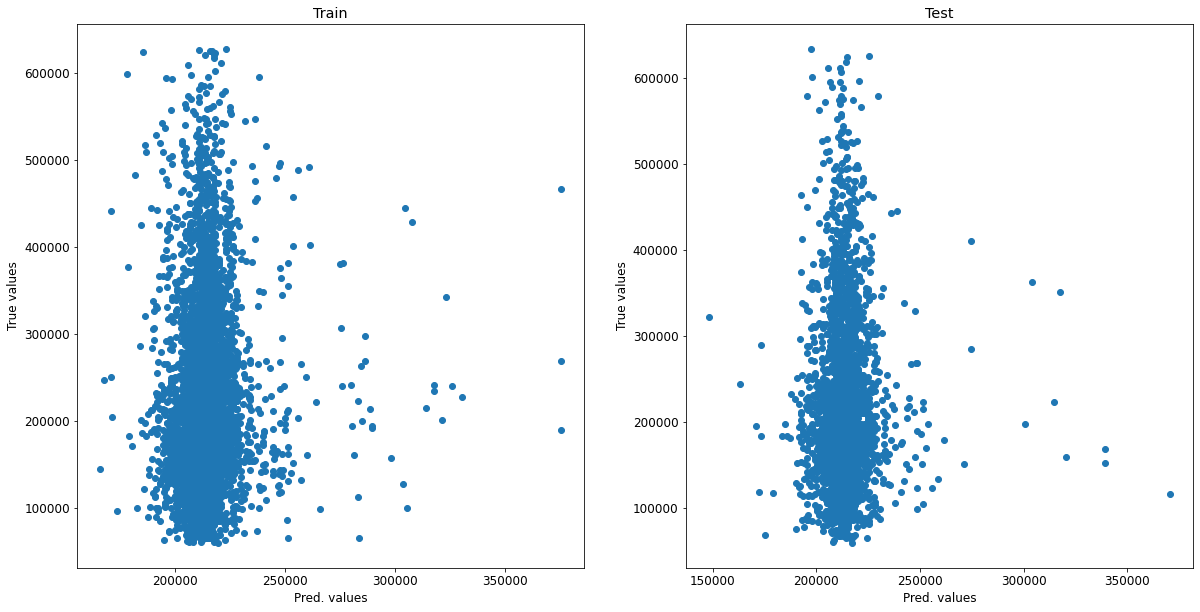

In [150]:
y_train_preds = stack.predict(X_train)
y_test_preds = stack.predict(X_valid)

pred_test_plot(y_train_preds, y_train, y_test_preds, y_valid)


In [151]:
predict_error(y_train_preds, y_train, metric = 'r2')
predict_error(y_train_preds, y_train, metric = 'r2')

Ошибка R2: 0.0019267534868723235
